In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm, mannwhitneyu, ttest_ind, shapiro
from tqdm.auto import tqdm
from scipy.stats import levene

In [55]:
df = pd.read_csv('hw_bootstrap.csv', sep=';')
df.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [64]:
df = df.drop(columns='Unnamed: 0')

KeyError: "['Unnamed: 0'] not found in axis"

In [65]:
df.isna().sum()

value                0
experimentVariant    0
dtype: int64

In [58]:
# преобразуем переменную value в числовой тип
df['value'] = df.value.str.replace(',', '.')
df['value'] = pd.to_numeric(df.value)

In [67]:
# сформируем тестовые группы
control = df.query('experimentVariant == "Control"').value
treatment = df.query('experimentVariant == "Treatment"').value

In [68]:
control.describe()[['mean', '50%']]

mean    10.026867
50%     10.018465
Name: value, dtype: float64

In [69]:
treatment.describe()[['mean', '50%']]

mean    27.321499
50%     10.025847
Name: value, dtype: float64

мы видим что средннее по группам существенно различается

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


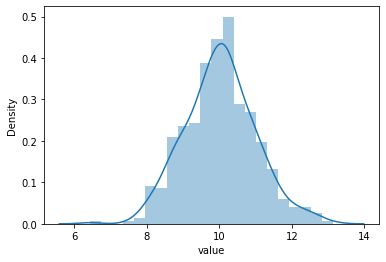

In [17]:
# построим распределение признака для контрольной и тестовой групп
sns.distplot(control)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


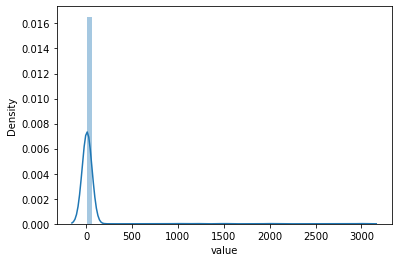

In [18]:
sns.distplot(treatment)

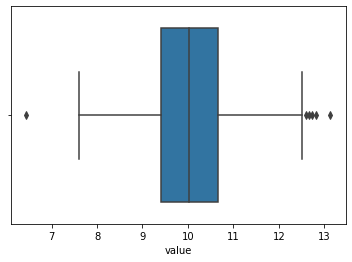

In [27]:
# посмотрим на боксплоты наших групп
sns.boxplot(x= control)

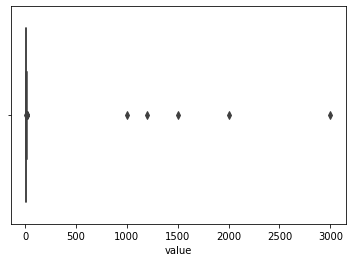

In [28]:
sns.boxplot(x = treatment)

In [29]:
# В тестовой группе распределение сильно отличается от нормального за счёт очень сильных выбросов в правой части
# графика. Оценим разницу между контрольной и тестовой группами с помощью непараметрического критерия Манна-Уитни.

In [30]:
mannwhitneyu(treatment, control).pvalue

0.8592148582485579

In [31]:
# Воспользуемся функцией для бутстрепа из лекции
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрепа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    statistic, # интересующая нас статистика
    bootstrap_conf_level = 0.95, # уровень значимости
    boot_it = 1000 # количество бутстрэп-подвыборок
    ):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
    # Визуализация
    sns.distplot(pd_boot_data[0])
       
    return {"ci": ci, 
            "p_value": p_value}

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


{'ci':                0
 0.025 -36.096746
 0.975  -3.894623,
 'p_value': 0.03730041365022507}

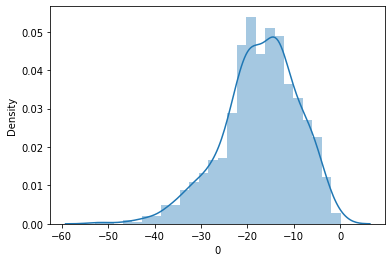

In [71]:
# применим функцию для средних значений
get_bootstrap(control, treatment, statistic = np.mean)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


{'ci':               0
 0.025 -0.156508
 0.975  0.113167,
 'p_value': 0.8419100113299889}

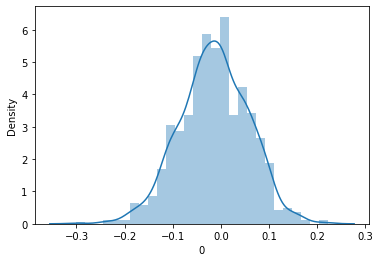

In [70]:
# теперь применим бутстреп для медиан
get_bootstrap(control, treatment, statistic = np.median)

In [35]:
# Уберём 5 выбросов из тестовой выборки
treat = df.query('experimentVariant == "Treatment"').sort_values('value').reset_index()[0:494].value

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


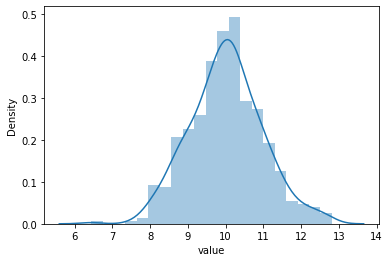

In [36]:
# построим распределение усеченной тестовой группы
sns.distplot(treat)

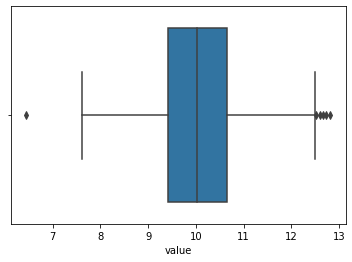

In [37]:
# оценим боксплотом рапределение
sns.boxplot(x = treat)

In [53]:
# проверим на нормальность обе группы тестом Шапиро
shapiro(control).pvalue

0.22416365146636963

In [46]:
shapiro(treat).pvalue

0.24110229313373566

In [52]:
# проверим имеют ли две группы одинаковые отклонения
levene(control, treat).pvalue

0.8500437925698866

In [51]:
# проведем Т-тест
ttest_ind(control, treat).pvalue

0.853149003855713

In [63]:
# тест Манна-Уитни
mannwhitneyu(control, treat).pvalue

0.8790787832087351

In [62]:
# итак, в тестовой группе оказались несколько значений с экстремально высокой выручкой, при учете данного факта и корректировке
# тестовой группы (путем удаления экстремальных значений) мы видим что тестовая и контрольная группы значимо не отличаются.
# Отвечая на вопрос задания "Стали ли мы больше зарабатывать с пользователя или нет?" можно ответить, что нет, так как
# срединй чек не изменился, что показали дальнейшие статистические исследования.
# Поскольку изначально в тестовой группе не выполнялось условие по нормальности распределения (наличие экстремальных
# выбросов), результаты бутстрепа по средним показали существенное различие в группах. 